In [2]:
import pandas as pd
import numpy as np

### Задание 1

Рассчитать маржу в рублях и % по всей компании в разрезе месяцев

Вывести: Месяц, Маржа руб., Маржа %. 
Предоставить запрос в SQL.

In [ ]:
select strftime('%Y-%m', date_create)  as month
        , sum(price_b2c_gross * quantity - cost_price * quantity) as margin
        , round(sum(cast(price_b2c_gross as real) * quantity - cast(cost_price as real) * quantity)
           /  sum(cast(price_b2c_gross as real)  * quantity) * 100, 2)  as margin_percent 
from t_orders
where status = 0
group by strftime('%Y-%m', date_create)  

### Задание 2

Выбрать топ 5 самых прибыльных позиций в разрезе каждого РК, за весь период.

In [ ]:
with sub as ( select organization_id
                      , code
                      , sum(price_b2c_gross * quantity - cost_price * quantity) as profit
                      , row_number() over (partition by organization_id 
                                           order by sum(price_b2c_gross * quantity - cost_price * quantity) desc
                                          ) as rn
              from t_orders
              where status = 0
              group by organization_id
                       , code
             )
select organization_id
        , code
        , profit        
from sub 
where rn <= 5
order by organization_id, rn

### Задание 3

В какой день недели клиенты чаще делают покупки. Проанализировать август.

Вывести: День недели, Среднее количество заказов в этот день

In [ ]:
select strftime('%w', date_create) as day_of_week  
        , count(distinct sales_order) 
                /  count(distinct strftime('%Y-%m-%d', date_create)) as avg_orders         
from t_orders 
where strftime('%Y-%m', date_create) = '2022-08'   -- предполагаю, что интересуют все заказы, а не только status=0
group by strftime('%w', date_create) 
order by avg_orders desc

Ответ: **вторник**

### Задание 4

Построить динамику доли выкупа заказов по их суммам в разрезе недель за июль.

Предоставить запрос в SQL + нарисовать диаграмму в Redash или Excel.

In [ ]:
select  strftime('%W', date_create) as week      
        , round(sum(case when status = 0 then cast(price_b2c_gross as real) * quantity else 0 end) 
            / sum(cast(price_b2c_gross as real) * quantity) * 100, 2) as ratio
from t_orders     
where strftime('%Y-%m', date_create) = '2022-07'
group by strftime('%Y-%W', date_create)
order by week

Визуализация из Excel:

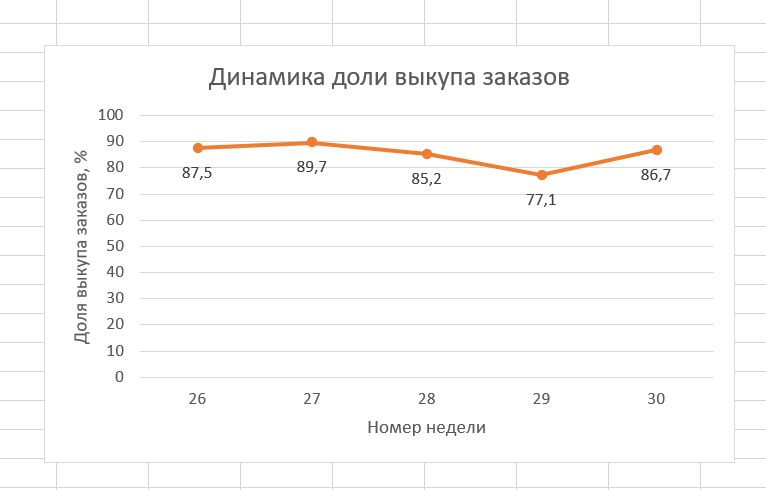

### Задание 5

Рассчитать за весь период товары, которые часто продаются друг с другом.

Вывести: Первый товар, Сопутствующий товар, Количество чеков с данными товарами

In [ ]:
with all_bills as ( select a.code as first_item
                           , b.code as second_item
                           , count(distinct a.sales_order) as bills
                           , rank() over (partition by a.code order by count(distinct a.sales_order) desc) as rank
                    from t_orders a
                    join t_orders b 
                        on a.sales_order = b.sales_order        
                    where a.code != b.code
                    group by a.code, b.code           
            )
select first_item
       , second_item
       , bills       
from all_bills     
where rank = 1
order by bills desc, first_item

ПРИМЕЧАНИЕ. В выводе есть парные строки А-B/B-А, у которых одинаковое количество счетов. Я посчитал, что их правильнее оставить, чтобы в колонке first_item были все возможные значения кода товара, без пропусков.

### Задание 6

Сформировать отчет в редаше с параметрами: Период, Тип отрезка.

Период - просто выбирает временной период без времени, Тип отрезка - группирует данные по дню, неделе, месяцу, году. 

**Запрос написан на диалекте ClickHouse**

In [ ]:
select  case when '{{Тип отрезка}}' = 'day' then toStartOfDay(time)
             when '{{Тип отрезка}}' = 'week' then toStartOfWeek(time)
             when '{{Тип отрезка}}' = 'month' then toStartOfMonth(time)
             when '{{Тип отрезка}}' = 'year' then toStartOfYear(time)
          end as time_interval
        , count(distinct user_id) as unique_users
from simulator_20211220.feed_actions
where toDate(time) >= '{{Период.start}}' and 
      toDate(time) <= '{{Период.end}}' 
group by time_interval

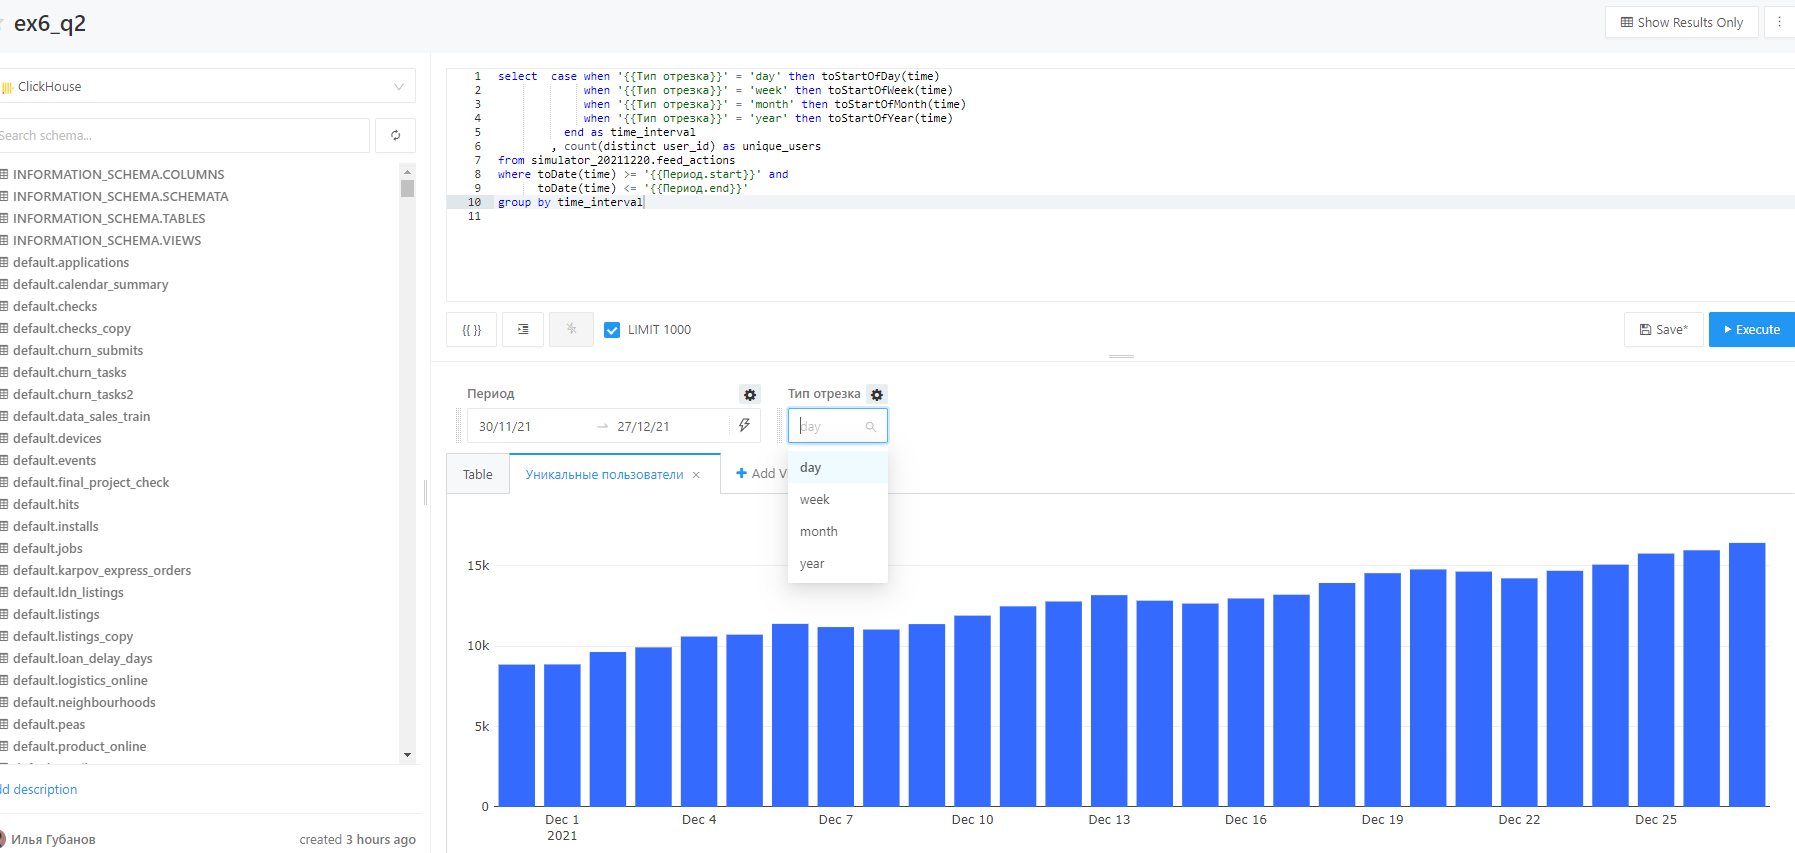

### Задание 7

Нужно распарсить и пронумеровать значения  в прямоугольных скобках в текущем порядке. 

Вывести 2 колонки: Порядковый номер, Значение. 

Предоставить решение в SQL и решение на Python

[[174.0,103.0,77.0,42.0,54.0,81.0,140.0,235.0,438.0,557.0,688.0,708.0,669.0,612.0,688.0,675.0,933.0,1015.0,998.0,834.0,861.0,658.0,617.0,414.0]]


#### SQLite

In [ ]:
create table ex7 (value real)
;

insert into ex7
select '[[174.0,103.0,77.0,42.0,54.0,81.0,140.0,235.0,438.0,557.0,688.0,708.0,669.0,612.0,688.0,675.0,933.0,1015.0,998.0,834.0,861.0,658.0,617.0,414.0]]' 
;

create table temp_numbers (num integer)
;

with recursive numbers as (
  select 1 as num
  union all
  select num + 1
  from numbers
  cross join ex7 
  where num < json_array_length(ex7.value, '$[0]') 
)
insert into temp_numbers
select num from numbers
;

select n.num as 'order_num',
       json_extract(ex7.value, '$[0][' || (n.num - 1) || ']') as 'value'
from temp_numbers as n
cross join ex7 
where n.num <= json_array_length(ex7.value, '$[0]')
;

drop table temp_numbers
;
drop table ex7
;

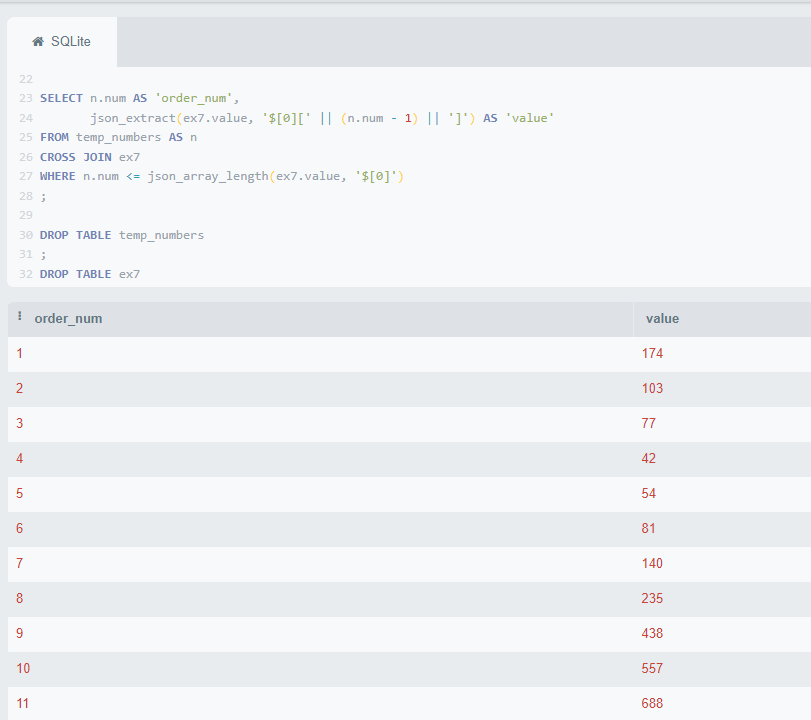

#### python

In [ ]:
nums = [[174.0,103.0,77.0,42.0,54.0,81.0,140.0,235.0,438.0,557.0,688.0,708.0,669.0,
         612.0,688.0,675.0,933.0,1015.0,998.0,834.0,861.0,658.0,617.0,414.0]]

In [5]:
for index, num in enumerate(nums[0]):
    print(index, num)                        # нумерация от нуля

0 174.0
1 103.0
2 77.0
3 42.0
4 54.0
5 81.0
6 140.0
7 235.0
8 438.0
9 557.0
10 688.0
11 708.0
12 669.0
13 612.0
14 688.0
15 675.0
16 933.0
17 1015.0
18 998.0
19 834.0
20 861.0
21 658.0
22 617.0
23 414.0


#### python + pandas

In [6]:
df = pd.DataFrame({'nums': nums})
df.explode('nums', ignore_index=True).reset_index(drop=False)

,index,nums
0,0,174.0
1,1,103.0
2,2,77.0
3,3,42.0
4,4,54.0
5,5,81.0
6,6,140.0
7,7,235.0
8,8,438.0
9,9,557.0
